### Implementing FunkSVD

In this notebook we will take a look at writing our own function that performs FunkSVD, which will follow the steps you saw in the previous video.  If you find that you aren't ready to tackle this task on your own, feel free to skip to the following video where you can watch as I walk through the steps.

To test our algorithm, we will run it on the subset of the data you worked with earlier.  Run the cell below to get started.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import svd_tests as t
%matplotlib inline

# Read in the datasets
movies = pd.read_csv('data/movies_clean.csv')
reviews = pd.read_csv('data/reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

# Create user-by-item matrix
user_items = reviews[['user_id', 'movie_id', 'rating', 'timestamp']]
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

# Create data subset
user_movie_subset = user_by_movie[[73486, 75314,  68646, 99685]].dropna(axis=0)
ratings_mat = np.matrix(user_movie_subset)
print(ratings_mat)

[[10. 10. 10. 10.]
 [10.  4.  9. 10.]
 [ 8.  9. 10.  5.]
 [ 9.  8. 10. 10.]
 [10.  5.  9.  9.]
 [ 6.  4. 10.  6.]
 [ 9.  8. 10.  9.]
 [10.  5.  9.  8.]
 [ 7.  8. 10.  8.]
 [ 9.  5.  9.  7.]
 [ 9.  8. 10.  8.]
 [ 9. 10. 10.  9.]
 [10.  9. 10.  8.]
 [ 5.  8.  5.  8.]
 [10.  8. 10. 10.]
 [ 9.  9. 10. 10.]
 [ 9.  8.  8.  8.]
 [10.  8.  1. 10.]
 [ 5.  6. 10. 10.]
 [ 8.  7. 10.  7.]]


In [43]:
import math
math.isnan(ratings_mat[0,0])

False

In [44]:
ratings_mat.shape

(20, 4)

`1.` You will use the **user_movie_subset** matrix to show that your FunkSVD algorithm will converge.  In the below cell, use the comments and document string to assist you as you complete writing your own function to complete FunkSVD.  You may also want to try to complete the function on your own without the assistance of comments.  You may feel free to remove and add to the function in any way that gets you a working solution! 

**Notice:** There isn't a sigma matrix in this version of the matrix factorization.

In [45]:
np.random.seed(1)
user_mat = np.random.rand(20, 4)
print(user_mat)
print(user_mat[0,:])
print(user_mat[:,0])

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01]
 [3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01]
 [2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01]
 [4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01]
 [8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02]
 [1.69830420e-01 8.78142503e-01 9.83468338e-02 4.21107625e-01]
 [9.57889530e-01 5.33165285e-01 6.91877114e-01 3.15515631e-01]
 [6.86500928e-01 8.34625672e-01 1.82882773e-02 7.50144315e-01]
 [9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01]
 [1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01]
 [2.87775339e-01 1.30028572e-01 1.93669579e-02 6.78835533e-01]
 [2.11628116e-01 2.65546659e-01 4.91573159e-01 5.33625451e-02]
 [5.74117605e-01 1.46728575e-01 5.89305537e-01 6.99758360e-01]
 [1.02334429e-01 4.14055988e-01 6.94400158e-01 4.141792

In [85]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = n_users * n_movies
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users, latent_features)  # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    user_movie_index = []
    #movie_index = []
    
    # check what is not NaN
    for user_i in range(n_users):
        for movie_j in range(n_movies):
            if(math.isnan(ratings_mat[user_i,movie_j])==False):
                user_movie_index.append([user_i,movie_j])
                #print(user_i,movie_j)
    
    
    # for each iteration
    sse = []
    for t in range(iters):
        
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        
        for pairs in user_movie_index:
            user_i = pairs[0]
            movie_j = pairs[1]
            
            # row of U
            #u = user_mat[user_i,:]
            # column of Vt
            #v = movie_mat[:,movie_j]
            
            # dot product
            uv_new = np.dot(user_mat[user_i,:], movie_mat[:,movie_j])
            delta = (ratings_mat[user_i, movie_j] - uv_new)
            #print(delta)
            sse_accum += delta**2.0 #sum of the square error
            
            for k in range(latent_features):
                user_mat[user_i,k] = user_mat[user_i,k] + 2.0 * (delta) * learning_rate * movie_mat[k,movie_j]
                
            for k in range(latent_features):
                movie_mat[k,movie_j] = movie_mat[k,movie_j] + 2.0 * (delta) * learning_rate * user_mat[user_i,k]  
            
            #user_mat[user_i,:] = u
            #movie_mat[:,movie_j] = v
        sse.append(sse_accum)
        if(t%10==0):
            print('iteration {}: sse_accum {}'.format(t+1, sse_accum))
    plt.plot(sse)  
    plt.title('iteration {}: sse_accum {}, learning rate {}'.format(t+1, sse_accum, learning_rate))
    plt.show()
    return user_mat, movie_mat 

`2.` Try out your function on the **user_movie_subset** dataset.  First try 4 latent features, a learning rate of 0.005, and 10 iterations.  When you take the dot product of the resulting U and V matrices, how does the resulting **user_movie** matrix compare to the original subset of the data?

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 3075.468828086074


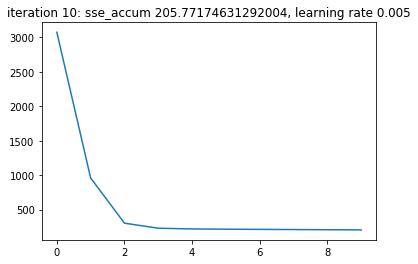

In [86]:
user_mat, movie_mat = FunkSVD(ratings_mat, 4, 0.005, 10) # use your function with 4 latent features, lr of 0.005 and 10 iterations

In [87]:
#Compare the predicted and actual results
print(np.dot(user_mat, movie_mat))
print(ratings_mat)

[[10.17440255  9.30088214 10.56029448  9.89102449]
 [ 8.58863914  7.2050941   9.17366212  8.87227587]
 [ 8.00666166  7.10188373  8.19987212  7.64766534]
 [ 9.53495297  8.0370823  10.08614784  9.6829593 ]
 [ 8.64313952  7.6472463   8.85444433  8.4459363 ]
 [ 6.75942751  5.60410549  7.52239141  6.87170633]
 [ 9.09791724  7.95722251 10.03926504  8.99245514]
 [ 8.22662478  7.0116464   8.71740898  8.19989578]
 [ 8.64229676  7.47032872  8.77024221  8.48814732]
 [ 7.60381134  6.75937399  8.09824702  7.67669231]
 [ 8.92507768  8.04810473  9.14759043  8.84148467]
 [ 9.62010794  8.54601844  9.9969267   9.51624491]
 [ 9.23037362  8.44402415  9.6313335   9.18168992]
 [ 6.61754929  5.91640389  6.9439074   6.54498274]
 [ 9.71937323  8.26819715 10.05894846 10.0496227 ]
 [ 9.89704301  8.49081728 10.05314254  9.81930095]
 [ 8.33235797  7.35425693  8.68147597  8.22593664]
 [ 7.15355781  6.31088362  7.2432515   7.17180124]
 [ 8.27908576  7.19592514  8.89495925  8.4110515 ]
 [ 8.05472357  6.88043018  8.50

**Write your summary here.**

`3.` Let's try out the function again on the **user_movie_subset** dataset.  This time we will again use 4 latent features and a learning rate of 0.005.  However, let's bump up the number of iterations to 250.  When you take the dot product of the resulting U and V matrices, how does the resulting **user_movie** matrix compare to the original subset of the data?  What do you notice about your error at the end of the 250 iterations?

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 3322.9917628448475
iteration 11: sse_accum 194.50302142982278
iteration 21: sse_accum 127.62071077964177
iteration 31: sse_accum 54.337122841673136
iteration 41: sse_accum 36.21773728247957
iteration 51: sse_accum 26.593610402759317
iteration 61: sse_accum 13.75840800309678
iteration 71: sse_accum 4.414873880359185
iteration 81: sse_accum 1.1210144287653225
iteration 91: sse_accum 0.29990907305956077
iteration 101: sse_accum 0.08780853336445614
iteration 111: sse_accum 0.026785387458575696
iteration 121: sse_accum 0.008274624830686549
iteration 131: sse_accum 0.002564238468160429
iteration 141: sse_accum 0.000795117500895816
iteration 151: sse_accum 0.00024657356900873703
iteration 161: sse_accum 7.647058602848124e-05
iteration 171: sse_accum 2.3719092086594678e-05
iteration 181: sse_accum 7.3582437448249825e-06
iteration 191: sse_accum 2.2831236652867626e-06
iteration 201: sse_accum 7.085388712508629e-07
i

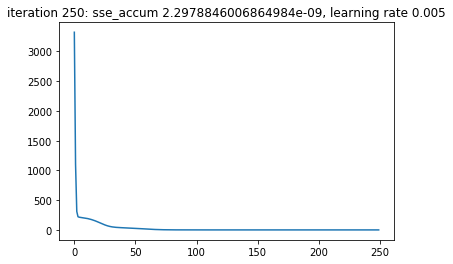

In [88]:
user_mat, movie_mat = FunkSVD(ratings_mat, 4, 0.005, 250) #use your function with 4 latent features, lr of 0.005 and 250 iterations

In [89]:
#Compare the predicted and actual results
print(np.dot(user_mat, movie_mat))
print(ratings_mat)

[[10.00000723 10.00000218 10.00000171  9.99999333]
 [10.00000174  4.00000044  9.00000031  9.99999838]
 [ 8.00000412  9.00000118 10.00000089  4.99999613]
 [ 8.9999922   7.99999758  9.99999805 10.00000706]
 [10.00000682  5.00000199  9.00000155  8.99999373]
 [ 5.9999851   3.99999555  9.99999648  6.00001358]
 [ 9.00000004  8.00000007 10.00000007  8.99999993]
 [10.00000288  5.00000089  9.0000007   7.99999734]
 [ 6.99999947  7.99999989  9.99999992  8.00000045]
 [ 9.00000141  5.00000043  9.00000034  6.99999868]
 [ 9.00001392  8.0000041  10.00000321  7.99998722]
 [ 8.99999699  9.99999895  9.9999991   9.00000264]
 [10.00000494  9.00000133 10.00000098  7.99999537]
 [ 5.00000135  8.00000029  5.00000019  7.9999987 ]
 [ 9.99999466  7.99999825  9.99999855 10.00000478]
 [ 8.99999937  8.99999973  9.99999975 10.0000005 ]
 [ 8.99999028  7.99999706  7.99999766  8.0000088 ]
 [ 9.99999755  7.99999926  0.99999941 10.00000217]
 [ 5.00000739  6.00000227 10.00000181  9.99999327]
 [ 7.99999533  6.99999861  9.99

**Write your summary here.**

The last time we placed an **np.nan** value into this matrix the entire svd algorithm in python broke.  Let's see if that is still the case using your FunkSVD function.  In the below cell, I have placed a nan into the first cell of your numpy array.  

`4.` Use 4 latent features, a learning rate of 0.005, and 250 iterations.  Are you able to run your SVD without it breaking (something that was not true about the python built in)?  Do you get a prediction for the nan value?  What is your prediction for the missing value? Use the cells below to answer these questions.

In [ ]:
# Here we are placing a nan into our original subset matrix
ratings_mat[0, 0] = np.nan
ratings_mat

In [ ]:
# run SVD on the matrix with the missing value
user_mat, movie_mat = #use your function with 4 latent features, lr of 0.005 and 250 iterations

In [ ]:
# Run this cell to see if you were able to predict for the missing value
preds = np.dot(user_mat, movie_mat)
print("The predicted value for the missing rating is {}:".format(preds[0,0]))
print()
print("The actual value for the missing rating is {}:".format(ratings_mat[0,0]))
print()
assert np.isnan(preds[0,0]) == False
print("That's right! You just predicted a rating for a user-movie pair that was never rated!")
print("But if you look in the original matrix, this was actually a value of 10. Not bad!")

Now let's extend this to a more realistic example. Unfortunately, running this function on your entire user-movie matrix is still not something you likely want to do on your local machine.  However, we can see how well this example extends to 1000 users.  In the above portion, you were using a very small subset of data with no missing values.

`5.` Given the size of this matrix, this will take quite a bit of time.  Consider the following hyperparameters: 4 latent features, 0.005 learning rate, and 20 iterations.  Grab a snack, take a walk, and this should be done running in a bit.

In [ ]:
# Setting up a matrix of the first 1000 users with movie ratings
first_1000_users = np.matrix(user_by_movie.head(1000))

# perform funkSVD on the matrix of the top 1000 users
user_mat, movie_mat = #fit to 1000 users with 4 latent features, lr of 0.005, and 20 iterations

`6.` Now that you have a set of predictions for each user-movie pair,  let's answer a few questions about your results. Provide the correct values for each of the variables below, and check your solutions using the tests below.

In [ ]:
# Replace each of the comments below with the correct values
num_ratings = # How many actual ratings exist in first_1000_users
print("The number of actual ratings in the first_1000_users is {}.".format(num_ratings))
print()


ratings_for_missing = # How many ratings did we make for user-movie pairs that didn't actually have ratings
print("The number of ratings made for user-movie pairs that didn't have ratings is {}".format(ratings_for_missing))

In [ ]:
# Test your results against the solution
assert num_ratings == 10852, "Oops!  The number of actual ratings doesn't quite look right."
assert ratings_for_missing == 31234148, "Oops!  The number of movie-user pairs that you made ratings for that didn't actually have ratings doesn't look right."

# Make sure you made predictions on all the missing user-movie pairs
preds = np.dot(user_mat, movie_mat)
assert np.isnan(preds).sum() == 0
print("Nice job!  Looks like you have predictions made for all the missing user-movie pairs! But I still have one question... How good are they?")